# Capstone: Musical Recommender

Kelly Slatery | US-DSI-10

In [1]:
# !python -m spacy download en_core_web_lg

In [2]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import regex as re
import unicodedata

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, pairwise_distances

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

# Import Data

In [3]:
df = pd.read_csv('./data/musical_data.csv')
df.shape

(194, 3)

In [4]:
df.head()

,name,plot_summary,synopsis
0,Les Misérables,"Act I In 1815 France, prisoners work at hard...",The musical takes place at the beginning of th...
1,The Phantom of the Opera,"Prologue In 1911 Paris, the Paris Opéra host...",At the beginning of the XX century in the Pari...
2,Hamilton,The musical details Hamilton's life in two ac...,Can we call a thing more boring than the histo...
3,West Side Story,"Act 1 Two rival teenage gangs, the Jets (Whi...","The two gangs – Jets, consisting of white & Sh..."
4,Wicked,"Act I In the Land of Oz, the Ozians are rejo...",Good Witch Glinda of Oz country reported that ...


In [5]:
df.isnull().sum()

name            0
plot_summary    0
synopsis        0
dtype: int64

In [6]:
df[df['plot_summary'] == ' '].count()

name            8
plot_summary    8
synopsis        8
dtype: int64

In [7]:
df[df['synopsis'] == ' '].count()

name            17
plot_summary    17
synopsis        17
dtype: int64

In [8]:
df[(df['plot_summary'] == ' ') | (df['synopsis'] == ' ')].count()

name            25
plot_summary    25
synopsis        25
dtype: int64

In [9]:
# Strip all leading and trailing spaces
df['plot_summary'] = [summ.strip() for summ in df['plot_summary']]
df['synopsis'] = [synopsis.strip() for synopsis in df['synopsis']]
df.head()

,name,plot_summary,synopsis
0,Les Misérables,"Act I In 1815 France, prisoners work at hard l...",The musical takes place at the beginning of th...
1,The Phantom of the Opera,"Prologue In 1911 Paris, the Paris Opéra hosts ...",At the beginning of the XX century in the Pari...
2,Hamilton,The musical details Hamilton's life in two act...,Can we call a thing more boring than the histo...
3,West Side Story,"Act 1 Two rival teenage gangs, the Jets (White...","The two gangs – Jets, consisting of white & Sh..."
4,Wicked,"Act I In the Land of Oz, the Ozians are rejoic...",Good Witch Glinda of Oz country reported that ...


In [10]:
# Create a column combining both summaries/synopses
df['combined'] = df['plot_summary'] + df['synopsis']
df.head()

,name,plot_summary,synopsis,combined
0,Les Misérables,"Act I In 1815 France, prisoners work at hard l...",The musical takes place at the beginning of th...,"Act I In 1815 France, prisoners work at hard l..."
1,The Phantom of the Opera,"Prologue In 1911 Paris, the Paris Opéra hosts ...",At the beginning of the XX century in the Pari...,"Prologue In 1911 Paris, the Paris Opéra hosts ..."
2,Hamilton,The musical details Hamilton's life in two act...,Can we call a thing more boring than the histo...,The musical details Hamilton's life in two act...
3,West Side Story,"Act 1 Two rival teenage gangs, the Jets (White...","The two gangs – Jets, consisting of white & Sh...","Act 1 Two rival teenage gangs, the Jets (White..."
4,Wicked,"Act I In the Land of Oz, the Ozians are rejoic...",Good Witch Glinda of Oz country reported that ...,"Act I In the Land of Oz, the Ozians are rejoic..."


# Data Stats

In [11]:
# Find the average word count of wikipedia summaries

# Remove punctuation, special characters, and numbers
wiki_summs = [re.sub(r'[^a-zA-Z0-9 ]+', '', summ) for summ in df['plot_summary']]

# Find the number of words per wiki summary
wiki_lengths = [len(summ.split()) for summ in wiki_summs]
wiki_lengths[:10]

[2453, 1873, 1082, 1269, 2203, 886, 1556, 1355, 1081, 1595]

In [12]:
# Mean number of words in wikipedia summaries
# Remove all instances of 0 from the list
wiki_lengths = list(filter(lambda x: x !=0, wiki_lengths))

# Find the mean and median
wiki_mean_word_count = np.mean(wiki_lengths)
wiki_median_word_count = np.median(wiki_lengths)

print(f'Mean word count: {wiki_mean_word_count}')
print(f'Median word count: {wiki_median_word_count}')
print(f'Min word count: {np.min(wiki_lengths)}')
print(f'Max word count: {np.max(wiki_lengths)}')

Mean word count: 1149.784946236559
Median word count: 1131.5
Min word count: 37
Max word count: 2715


In [13]:
# Find the average word count of all musicals summaries

# Remove punctuation, special characters, and numbers
allm_summs = [re.sub(r'[^a-zA-Z0-9 ]+', '', summ) for summ in df['synopsis']]

# Find the number of words per all musicals summary
allm_lengths = [len(summ.split()) for summ in allm_summs]
allm_lengths[:10]

[727, 626, 396, 623, 541, 497, 539, 204, 446, 676]

In [14]:
# Mean number of words in allmpedia summaries
# Remove all instances of 0 from the list
allm_lengths = list(filter(lambda x: x !=0, allm_lengths))

# Find the mean and median
allm_mean_word_count = np.mean(allm_lengths)
allm_median_word_count = np.median(allm_lengths)

print(f'Mean word count: {allm_mean_word_count}')
print(f'Median word count: {allm_median_word_count}')
print(f'Min word count: {np.min(allm_lengths)}')
print(f'Max word count: {np.max(allm_lengths)}')

Mean word count: 487.20338983050846
Median word count: 509.0
Min word count: 41
Max word count: 1228


# Data Cleaning

In [15]:
# Load the large spaCy English model, pre-trained on web text data
nlp = en_core_web_lg.load()

In [16]:
# Import and customize spaCy stopwords
stopwords = list(STOP_WORDS)
len(stopwords)

326

In [17]:
# Remove parts of contractions for CountVectorizer compatability
stopwords_full_words = [word for word in stopwords if word.isalpha()]
print(stopwords_full_words[:10])

['moreover', 'not', 'cannot', 'twenty', 'becoming', 'forty', 'fifty', 'give', 'whereafter', 'she']


In [18]:
# Find most common words in my corpus to add to spaCy's list of stopwords
X = df['combined']
cvec = CountVectorizer(max_features=25, stop_words=stopwords_full_words)
cvec.fit(X);

In [19]:
print(cvec.get_feature_names())

['act', 'asks', 'away', 'day', 'family', 'father', 'find', 'girl', 'home', 'leave', 'life', 'love', 'man', 'mother', 'new', 'old', 'people', 'reprise', 'song', 'soon', 'tells', 'time', 'wife', 'woman', 'young']


In [20]:
# Add common words from above with no relevance to semantic meaning to stopwords
stopwords_to_append = ['act', 'act i', 'act ii', 'act iii', 'reprise', 'people', 'synopsis', 'plot summary', 'summary']
for word in stopwords_to_append:
    stopwords.append(word)

# Verify that words were added
print(stopwords[-len(stopwords_to_append):])

['act', 'act i', 'act ii', 'act iii', 'reprise', 'people', 'synopsis', 'plot summary', 'summary']


In [21]:
# Define a function to replace all non-ASCII characters in a string document or a Spacy Doc and return a spaCy Doc
def replace_ASCII(doc):
    
    # Credits (UnicodeDecodeError): @Vincent Marchetti 10.13.2008, https://stackoverflow.com/questions/196345/how-to-check-if-a-string-in-python-is-in-ascii
    # Credits (unicodedata): @Mini Quark 02.05.2009, https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-in-a-python-unicode-string
    try:
        try:
            doc.encode('utf-8').decode('ascii')
        except UnicodeDecodeError:
            doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf-8')
    except AttributeError:
        doc = str(doc)
        try:
            doc.encode('utf-8').decode('ascii')
        except UnicodeDecodeError:
            doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf-8')
    doc = nlp(doc)
    
    return doc

Remove all stopwords from spaCy's predefined list of stopwords (the most commonly occurring words, from their data and algorithms), along with most commonly occurring words in my corpus that seem unrelated to content.

In [22]:
# Define a function to tokenize text and remove spaCy stopwords + appended stopwords
def remove_stopwords(doc):
    not_stopwords = []
    for token in doc:
        if (not token.is_stop) and token.text.lower() not in stopwords:
            not_stopwords.append(token)
    return not_stopwords

In [23]:
# Define a function to remove all punctuation and numbers from the tokens list
def words_only(token_list):
    words_only = [token for token in token_list if token.text.isalpha()]
    return words_only

In [24]:
# Define a function to remove all words that are not nouns, verbs, adjectives, or adverbs from a list of token
def remove_unimportant_POS(token_list):
    important_pos = [token for token in token_list if token.pos_ in ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']]
    return important_pos
# poss = [token for token in lesmis2 if token.pos_ in ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']]

In [25]:
# Define a function to lemmatize all the token in a token list and return a list of strings
def lemmatize_tokens(token_list):
    lemmas = [token.lemma_ for token in token_list]
    return lemmas

In [26]:
lesmis = nlp(df['combined'][0])

In [27]:
type(nlp(' '.join(lemmatize_tokens(remove_unimportant_POS(words_only(remove_stopwords(replace_ASCII(lesmis)))))[0])))

spacy.tokens.doc.Doc

In [28]:
# Define a function to preprocess text data (to be used on user input as well) and return a list of Tokens
def process_text(text):
    text = replace_ASCII(text)
    token_list = remove_stopwords(text)
    token_list = words_only(token_list)
    token_list = remove_unimportant_POS(token_list) 
    string_list = lemmatize_tokens(token_list)
    return string_list

In [29]:
# Define a function to turn a list of tokens into a spaCy Doc
def convert_to_doc(string_list):
    doc = nlp(' '.join(string_list))
    return doc

# Process Data

In [30]:
# Look at dataframe and drop unnecessary columns
df.head()

,name,plot_summary,synopsis,combined
0,Les Misérables,"Act I In 1815 France, prisoners work at hard l...",The musical takes place at the beginning of th...,"Act I In 1815 France, prisoners work at hard l..."
1,The Phantom of the Opera,"Prologue In 1911 Paris, the Paris Opéra hosts ...",At the beginning of the XX century in the Pari...,"Prologue In 1911 Paris, the Paris Opéra hosts ..."
2,Hamilton,The musical details Hamilton's life in two act...,Can we call a thing more boring than the histo...,The musical details Hamilton's life in two act...
3,West Side Story,"Act 1 Two rival teenage gangs, the Jets (White...","The two gangs – Jets, consisting of white & Sh...","Act 1 Two rival teenage gangs, the Jets (White..."
4,Wicked,"Act I In the Land of Oz, the Ozians are rejoic...",Good Witch Glinda of Oz country reported that ...,"Act I In the Land of Oz, the Ozians are rejoic..."


In [31]:
df.drop(columns=['plot_summary', 'synopsis'], inplace=True)

In [32]:
# Create a new column of processed spaCy docs
df['clean_combined'] = [convert_to_doc(process_text(summ)) for summ in df['combined']]
print(type(df['clean_combined'][0]))
df.head()

<class 'spacy.tokens.doc.Doc'>


,name,combined,clean_combined
0,Les Misérables,"Act I In 1815 France, prisoners work at hard l...","(France, prisoner, work, hard, labour, work, s..."
1,The Phantom of the Opera,"Prologue In 1911 Paris, the Paris Opéra hosts ...","(prologue, Paris, Paris, Opera, host, auction,..."
2,Hamilton,The musical details Hamilton's life in two act...,"(musical, detail, Hamilton, life, act, histori..."
3,West Side Story,"Act 1 Two rival teenage gangs, the Jets (White...","(rival, teenage, gang, jet, White, Americans, ..."
4,Wicked,"Act I In the Land of Oz, the Ozians are rejoic...","(Land, Oz, Ozians, rejoice, demise, Elphaba, W..."


In [33]:
# Create a new column of each spaCy doc's vector
df['vectors'] = [doc.vector for doc in df['clean_combined']]
print(type(df['vectors'][0]))
df.head()

<class 'numpy.ndarray'>


,name,combined,clean_combined,vectors
0,Les Misérables,"Act I In 1815 France, prisoners work at hard l...","(France, prisoner, work, hard, labour, work, s...","[-0.002553087, 0.12506698, -0.00378664, -0.008..."
1,The Phantom of the Opera,"Prologue In 1911 Paris, the Paris Opéra hosts ...","(prologue, Paris, Paris, Opera, host, auction,...","[0.045305878, 0.04773137, -0.026332987, 0.0545..."
2,Hamilton,The musical details Hamilton's life in two act...,"(musical, detail, Hamilton, life, act, histori...","[-0.0679643, 0.12197779, 0.013358698, -0.06643..."
3,West Side Story,"Act 1 Two rival teenage gangs, the Jets (White...","(rival, teenage, gang, jet, White, Americans, ...","[-0.031628724, 0.06836412, -0.04604004, 0.0160..."
4,Wicked,"Act I In the Land of Oz, the Ozians are rejoic...","(Land, Oz, Ozians, rejoice, demise, Elphaba, W...","[0.01180185, 0.05791358, -0.0018458304, 0.0469..."


# Export Data

In [34]:
# Export new dataframe with processed data in spaCy Docs and vectors
df.to_csv('./data/musical_vectors.csv', index=False)

# Model Data

In [35]:
# Define X and train, test, split
X = df['vectors']
X = np.matrix(X.tolist())

#### KMeans

In [36]:
# Instantiate and fit a gridsearch for a KMeans clustering model
km = KMeans()
params = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10] #, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
}
gs = GridSearchCV(km, params, cv=5)
gs.fit(X)

# Get the best estimator
print(gs.best_estimator_)
print(silhouette_score(X, gs.best_estimator_.labels_))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
0.03163792


In [37]:
# Create new column with KMeans labels and look at distribution of labels
df['km_labels'] = gs.best_estimator_.labels_
df['km_labels'].value_counts()

6    44
8    29
5    27
7    24
3    20
0    16
4    12
2    11
1     6
9     5
Name: km_labels, dtype: int64

In [38]:
# Define a function to create a dictionary of labels and musical names
def group_musicals_dict(df, col):
    musical_dict = {}
    for i in range(len(df[col].value_counts())):
        musical_dict[i] = list(df.loc[df[col] == i, 'name'].values)
    return musical_dict

In [39]:
# Define a function to create a dictionary of labels and musical names
def group_musicals_dict(df, col):
    musical_dict = {}
    for i in df[col].unique():
        musical_dict[i] = list(df.loc[df[col] == i, 'name'].values)
    return musical_dict

In [40]:
# Define a function to create a dataframe of musical names and their labels
def group_musicals_df(dictionary):
    musical_df = pd.DataFrame()
    for key, value in dictionary.items():
        series = pd.Series(value, name=key)
        musical_df = pd.concat([musical_df, series], join='outer', axis=1)
    return musical_df

In [41]:
# Create a dataframe grouping musicals by their KMeans labels
km_musical_groups_df = group_musicals_df(group_musicals_dict(df, 'km_labels'))
km_musical_groups_df.head()

,0,1,6,3,7,2,5,4,9,8
0,Les Misérables,Hamilton,West Side Story,Wicked,The Book of Mormon,Sweeney Todd: The Demon Barber of Fleet Street,The Sound of Music,A Chorus Line,Jesus Christ Superstar,Mary Poppins
1,The Phantom of the Opera,1776,Chicago,Into the Woods,Evita,Dear Evan Hansen,Fiddler on the Roof,Singin' in the Rain,Joseph and the Amazing Technicolor Dreamcoat,Kinky Boots
2,The Lion King,Starlight Express,Rent,Little Shop of Horrors,Pippin,My Fair Lady,Annie,Dreamgirls,Godspell,Next to Normal
3,Camelot,pajama game,Hairspray,Beauty and the Beast,The Producers,"Hello, Dolly!",Matilda,Jersey Boys,Tarzan of the Apes,Waitress
4,Man of La Mancha,Parade,Cabaret,Cats,How to Succeed in Business Without Really Trying,Oliver!,Spring Awakening,School of Rock - the Musical,Children of Eden,Ragtime


#### DBSCAN

In [42]:
# Find average distance between vectors to help determine epsilon value
cos_sims = 0
count = 0
for summ1 in df['clean_combined']:
    for summ2 in df['clean_combined']:
        if summ1.similarity(summ2) != 1:
            cos_sims += summ1.similarity(summ2)
            count += 1
avg_vector_distance = cos_sims / count
print(avg_vector_distance)

0.9240219128411031


In [43]:
# Instantiate, fit, and score a DBSCAN clustering model
db = DBSCAN(eps=.92, min_samples=10)
db.fit(X)
silhouette_score(X, db.labels_)

0.18752106

In [44]:
# Create new column with DBSCAN labels and look at distribution of labels
df['db_labels'] = db.labels_
df['db_labels'].value_counts()

 0    172
-1     22
Name: db_labels, dtype: int64

In [45]:
# Create a dataframe grouping musicals by their DBSCAN labels
db_musical_groups_df = group_musicals_df(group_musicals_dict(df, 'db_labels'))
db_musical_groups_df.head()

,0,-1
0,Les Misérables,The Lion King
1,The Phantom of the Opera,Fiddler on the Roof
2,Hamilton,Jesus Christ Superstar
3,West Side Story,Cinderella
4,Wicked,The Little Mermaid


# Export Labeled Data

In [46]:
# Export df with both labeled groups
df.to_csv('./data/musical_data_vectors_labels.csv', index=False)

In [47]:
# Export dataframes with labels as column names
km_musical_groups_df.to_csv('./data/kmeans_labels.csv', index=False)

In [48]:
db_musical_groups_df.to_csv('./data/dbscan_labels.csv', index=False)

# Visualize Data

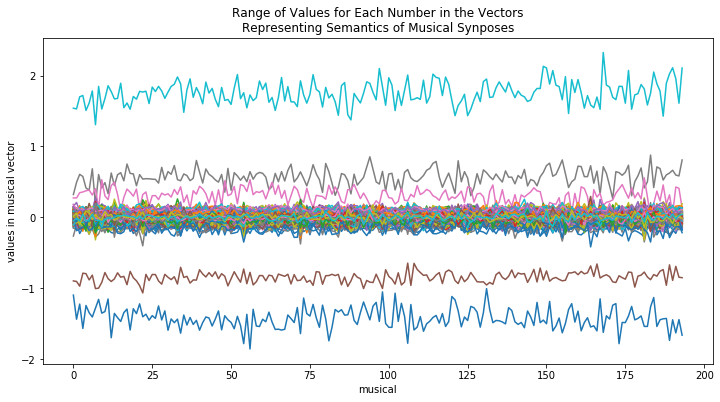

In [49]:
# Visualize vectors plotted in space (range at each value, centrality of vectors)
plt.figure(figsize=(12,6))
plt.plot(X)
plt.xlabel('musical')
plt.ylabel('values in musical vector')
plt.title('Range of Values for Each Number in the Vectors\nRepresenting Semantics of Musical Synposes');

It is difficult to visualize text data, so this visual does not give us too much information. What it does show us is that in general, at each element in the musicals' vectorizations, values do not differ much from one another, varying by a unit of around 1 at most, it appears. Though I am not familiar with how vectorizations might compare in a different scenario, this graph makes sense given the knowledge that we are looking at texts from only two different sources with the general writing style, so they are likely to have similar vectorizations.

In [50]:
# Get the cosine similarity between each pair of documents, and look at the correlations (closeness)
vector_distances = pd.DataFrame(pairwise_distances(X, X, metric='cosine'))
vector_distances.corr().head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,1.000000,0.639320,0.423008,0.552172,0.706808,0.641505,0.498313,0.518874,0.644255,0.739856,...,0.513814,0.451320,0.398291,0.240229,0.419079,0.426926,0.394986,0.590503,0.441636,0.294799
1,0.639320,1.000000,0.434439,0.708048,0.775504,0.757585,0.637318,0.402847,0.522906,0.712627,...,0.372634,0.597003,0.663101,0.545108,0.547963,0.641612,0.556228,0.679763,0.771140,0.518438
2,0.423008,0.434439,1.000000,0.693267,0.254201,0.605965,0.741157,-0.063010,0.656144,0.694083,...,0.790917,0.520309,0.536088,0.629975,0.419224,0.505581,0.468668,0.538377,0.593795,0.391943
3,0.552172,0.708048,0.693267,1.000000,0.543384,0.838232,0.895521,0.171727,0.614893,0.793721,...,0.666013,0.822350,0.816825,0.803751,0.640242,0.765291,0.620566,0.850964,0.870974,0.657936
4,0.706808,0.775504,0.254201,0.543384,1.000000,0.650931,0.503541,0.577357,0.548330,0.676746,...,0.269975,0.568386,0.534481,0.330605,0.520290,0.547599,0.435742,0.672112,0.614565,0.494788


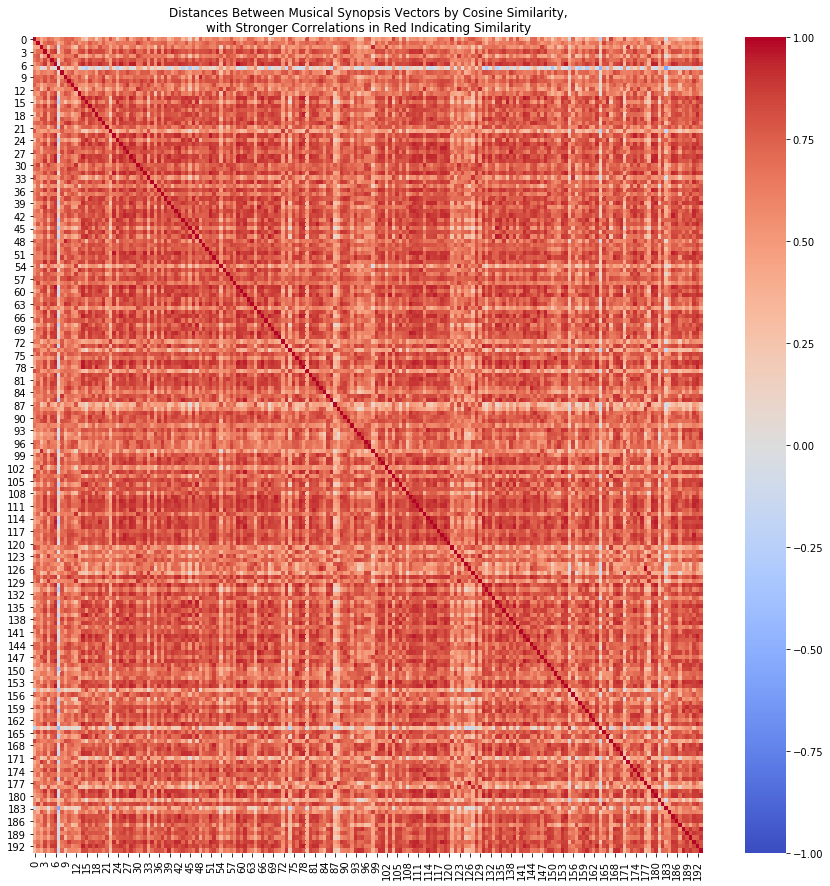

In [51]:
# Visualize the strength of relatedness of different musicals synopses using cosine similarity
plt.figure(figsize=(15,15))
sns.heatmap(vector_distances.corr(), vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Distances Between Musical Synopsis Vectors by Cosine Similarity,\nwith Stronger Correlations in Red Indicating Similarity');

Though this heatmap is very busy and is not helpful for pulling out any specific insights from our data, we do see that the vectors are generally quite close together (darker red), indicating that musical synopses are quite similar according to their spaCy vectorization. We also see that the musical at index 7 ('Lion King') is negatively correlated with the majority of the other musicals, which may be due to its main characters being animals.